# Plot lots of ACCESS-OM3 timeseries

https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/Model_Agnostic_Analysis.ipynb

In [1]:
%matplotlib inline
import pandas as pd
import intake
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cftime
import xgcm
import os

import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client

In [2]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [3]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

In [4]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44113 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44113/status,
Dashboard: /proxy/44113/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37485,Workers: 0
Dashboard: /proxy/44113/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35235,Total threads: 1
Dashboard: /proxy/43581/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39073,


In [5]:
thisdir = '/g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/'

In [6]:
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.iss138/'
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.testAug2024/'
# datastore = intake.open_esm_datastore(PATH+'intake_datastore.json', columns_with_iterables=['variable'])

In [7]:
#PATH='/g/data/tm70/ml0072/COMMON/git_repos/test-Reichl-2025-04-continue/archive/'
#datastore = intake.open_esm_datastore(PATH+'intake_esm_ds.json', columns_with_iterables=['variable'])

OLD - REDUNDANT

https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/523926733

Everything is here
/g/data/tm70/ml0072/COMMON/git_repos/control_runs/ctrl_25km_1st_version

where

dev-MC_025deg_jra_ryf_alpha_rel covers year 00-19

test-Reichl-2025-04-continue covers 20-48

ctrl_run_25km_0.5 currently covers 49-62. Ongoing data will be temporarily transferred here as well.

dev-MC_025deg_jra_ryf_alpha_rel and test-Reichl-2025-04-continue share the same topo, but different MOM_parameters and different timesteps
the topos are different from test-Reichl-2025-04-continue and ctrl_run_25km_0.5 but they share the same MOM_parameters


https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/529767260
```
/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2
/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2_only_neutral_diffusion
/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235
```
These are the three runs related to https://github.com/ACCESS-NRI/access-om3-configs/issues/647#issuecomment-3086863360
`choice2` does not use density coords but is otherwise and identical config to the beta release.

------------------------------

```
/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR
```
is the "formal" beta release run with all settings exactly as on github. It has currently finished 7 years. I plan to continue running it throughout the week and aim to reach 20 years by the end of the week.


In [8]:
catalogs = [
                '/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235/archive/experiment_datastore.json',
                # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2_only_neutral_diffusion/archive/experiment_datastore.json',
                # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2/archive/experiment_datastore.json',
                '/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR/archive/experiment_datastore.json',
            ]
catalogs

['/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235/archive/experiment_datastore.json',
 '/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR/archive/experiment_datastore.json']

In [9]:
datastores = { os.path.normpath(c).split(os.sep)[-3]: intake.open_esm_datastore(c, columns_with_iterables=['variable']) for c in catalogs }
datastores

{'om3_MC_25km_jra_ryf_631+634+235': <experiment_datastore catalog with 37 dataset(s) from 1148 asset(s)>,
 'test_current_config_0.0_w_rho_coord_with_GM_RR': <experiment_datastore catalog with 41 dataset(s) from 4873 asset(s)>}

In [10]:
# ACCESS-OM2-025 experiment
# use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258
om2expt = '025deg_jra55_ryf9091_gadi'
om2cat = intake.cat.access_nri[om2expt]

In [11]:
# get coords from short run without processor masking
# https://github.com/aekiss/MOM6-CICE6/commit/59ed8ffc6ae1d4a79821a951924e7c853d9b788a
# https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#A-note-on-geographical-coordinates
static = xr.open_dataset('/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc')

In [12]:
static

<xarray.Dataset> Size: 368MB
Dimensions:       (xh: 1440, yh: 1142, time: 1, xq: 1440, yq: 1142)
Coordinates:
  * xh            (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yh            (yh) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.95
  * time          (time) object 8B 1900-01-01 00:00:00
  * xq            (xq) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yq            (yq) float64 9kB -80.9 -80.84 -80.77 ... 89.79 89.9 90.0
Data variables: (12/28)
    areacello     (yh, xh) float64 13MB ...
    areacello_cu  (yh, xq) float64 13MB ...
    areacello_cv  (yq, xh) float64 13MB ...
    areacello_bu  (yq, xq) float64 13MB ...
    dxt           (yh, xh) float64 13MB ...
    dyt           (yh, xh) float64 13MB ...
    ...            ...
    dxCu          (yh, xq) float64 13MB ...
    dyCu          (yh, xq) float64 13MB ...
    dxCv          (yq, xh) float64 13MB ...
    dyCv          (yq, xh) float64 13MB ...
    dyCuo         (yh, xq) float64 13MB ...
    dxCvo         (yq, xh) float64 13MB ...
Attributes:
    NumFilesInSet:  1
    title:          ACCESS-OM3
    grid_type:      regular
    grid_tile:      N/A
    history:        created with https://github.com/aekiss/MOM6-CICE6/commit/...

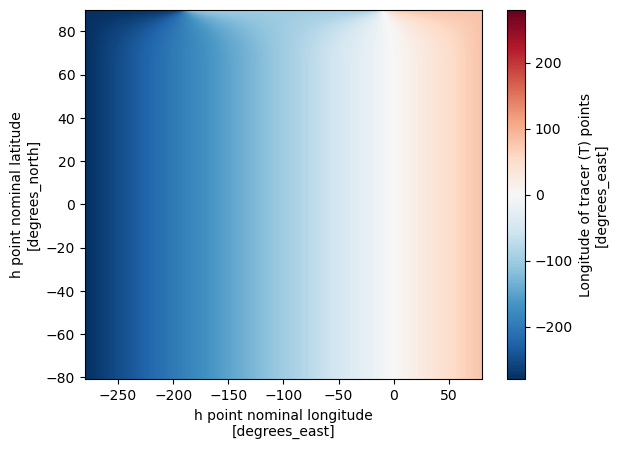

In [13]:
static['geolon'].plot()

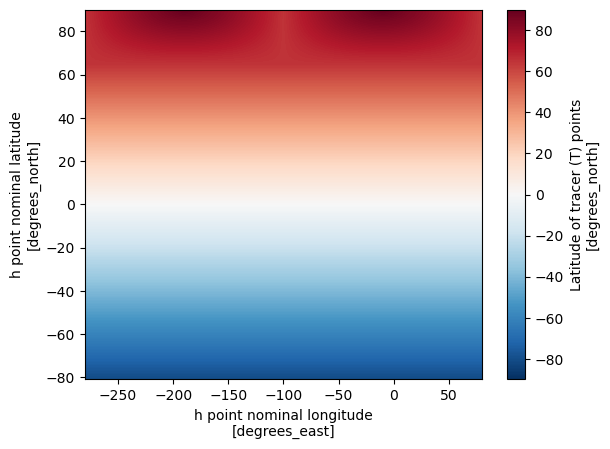

In [14]:
static['geolat'].plot()

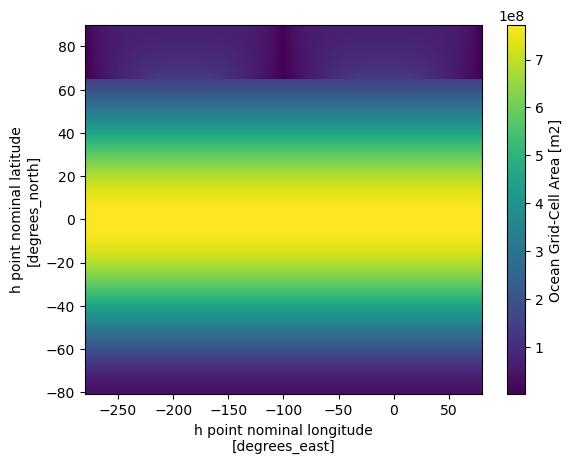

In [15]:
static['areacello'].plot()

see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition

ACCESS-OM3 uses a non-symmetric memory layout, i.e. all fields have the same i and j sizes. See
https://mom6.readthedocs.io/en/main/api/generated/pages/Horizontal_Indexing.html?highlight=symmetric#declaration-of-variables

`MOM_parameter_doc.layout`:
```
!SYMMETRIC_MEMORY_ = False      !   [Boolean]
                                ! If defined, the velocity point data domain includes every face of the
                                ! thickness points. In other words, some arrays are larger than others,
                                ! depending on where they are on the staggered grid.  Also, the starting index
                                ! of the velocity-point arrays is usually 0, not 1. This can only be set at
                                ! compile time.```


In [16]:
# for non-symmetric 
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

In [17]:
fields = { # key is OM3 name, value is OM2 name
    # keys from ncdump -h ctrl_run_25km_0.5/archive/output009/access-om3.mom6.scalar.1day.snap.1962.nc | grep double
    'soga': 'salt_global_ave',
    'thetaoga': 'temp_global_ave',
    'tosga': 'temp_surface_ave',
    'sosga': 'salt_surface_ave',
    # 'total_salt_Flux_Added': None,
    # 'total_salt_Flux_In': None,
    # 'total_salt_flux': None,
    # 'net_fresh_water_global_adjustment': None,
    # 'salt_flux_global_restoring_adjustment': None,
    # 'total_wfo': None,
    # 'total_evs': None,
    # 'total_fsitherm': None,
    # 'total_precip': None,
    # 'total_prsn': None,
    # 'total_lprec': None,
    # 'total_ficeberg': None,
    # 'total_friver': None,
    # 'total_net_massout': None,
    # 'total_net_massin': None,
}
fields

{'soga': 'salt_global_ave',
 'thetaoga': 'temp_global_ave',
 'tosga': 'temp_surface_ave',
 'sosga': 'salt_surface_ave'}

In [18]:
data = dict()
for k, om2 in fields.items():
    print(k)
    # d = [ ds.search(variable=k).to_dataset_dict(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for ds in datastores ]
    try:
        d = { n: ds.search(variable=k) for n, ds in datastores.items() }
        d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
    except ValueError:
        try:
            d = { n: ds.search(variable=k, frequency='1mon', variable_cell_methods='.*time: mean.*') for n, ds in datastores.items() }
            d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
        except:
            try:
                d = { n: ds.search(variable=k, variable_cell_methods='.*time: mean.*') for n, ds in datastores.items() }
                d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
            except:
                try:
                    d = { n: ds.search(variable=k, variable_cell_methods='.*time: point.*') for n, ds in datastores.items() }
                    d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
                except:
                    try:
                        d = { n: ds.search(variable=k, variable_cell_methods='.*time: min.*') for n, ds in datastores.items() }
                        d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
                    except:
                        try:
                            d = { n: ds.search(variable=k, variable_cell_methods='.*time: max.*') for n, ds in datastores.items() }
                            d = { n: ds.to_dask() for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
                        except:
                            print(f'{k} failed')
                            continue
    if om2 is None: # add access-om2 data,with variable name changed to match om3
        d2 = {}
    else:
        # d[om2expt] = om2cat.search(variable=om2).to_dask().rename({om2: k})
        d2 = {om2expt: om2cat.search(variable=om2).to_dask().rename({om2: k})}
    # if d:
    #     data[k] = xr.concat(d, 'time')
    # else:
    #     print(f'no data for {k}')
    # break
    data[k] = d2 | d
    # break
data

soga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To sile

thetaoga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into 

tosga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.d

sosga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

{'soga': {'025deg_jra55_ryf9091_gadi': <xarray.Dataset> Size: 125kB
  Dimensions:      (time: 7800, scalar_axis: 1)
  Coordinates:
    * scalar_axis  (scalar_axis) float64 8B 0.0
    * time         (time) object 62kB 1900-01-16 12:00:00 ... 2549-12-16 12:00:00
  Data variables:
      soga         (time, scalar_axis) float64 62kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  Attributes: (12/16)
      filename:                                 ocean_scalar.nc
      title:                                    ACCESS-OM2-025
      grid_type:                                mosaic
      grid_tile:                                1
      intake_esm_vars:                          ['salt_global_ave']
      intake_esm_attrs:filename:                ocean_scalar.nc
      ...                                       ...
      intake_esm_attrs:variable_standard_name:  ,,,,,sea_water_potential_temper...
      intake_esm_attrs:variable_cell_methods:   ,,,time: mean,time: mean,time: ...
      intake_esm_at

In [19]:
data.keys()

dict_keys(['soga', 'thetaoga', 'tosga', 'sosga'])

In [20]:
data

{'soga': {'025deg_jra55_ryf9091_gadi': <xarray.Dataset> Size: 125kB
  Dimensions:      (time: 7800, scalar_axis: 1)
  Coordinates:
    * scalar_axis  (scalar_axis) float64 8B 0.0
    * time         (time) object 62kB 1900-01-16 12:00:00 ... 2549-12-16 12:00:00
  Data variables:
      soga         (time, scalar_axis) float64 62kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  Attributes: (12/16)
      filename:                                 ocean_scalar.nc
      title:                                    ACCESS-OM2-025
      grid_type:                                mosaic
      grid_tile:                                1
      intake_esm_vars:                          ['salt_global_ave']
      intake_esm_attrs:filename:                ocean_scalar.nc
      ...                                       ...
      intake_esm_attrs:variable_standard_name:  ,,,,,sea_water_potential_temper...
      intake_esm_attrs:variable_cell_methods:   ,,,time: mean,time: mean,time: ...
      intake_esm_at

In [21]:
# set date range
trange = slice(cftime.DatetimeNoLeap(1900, 1, 1, 0, 0, 0, 0),
               cftime.DatetimeNoLeap(1926, 1, 1, 0, 0, 0, 0))

soga
saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/soga_Global_Mean_Ocean_Salinity-IC.png
thetaoga
saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/thetaoga_Global_Mean_Ocean_Potential_Temperature-IC.png
tosga
saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/tosga_Sea_Surface_Temperature-IC.png
sosga
saved /g/data/v45/aek156/notebooks/github/aekiss/access-eval-recipes/ocean/sosga_Sea_Surface_Salinity-IC.png


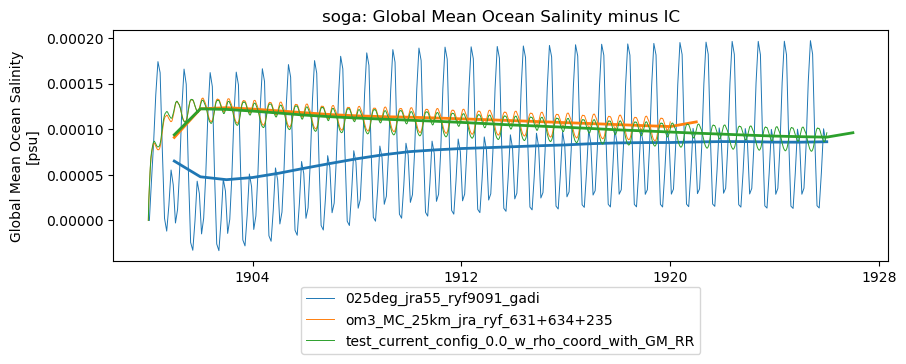

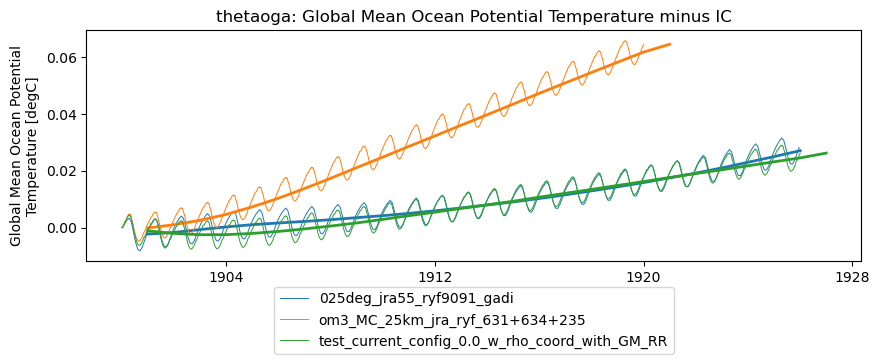

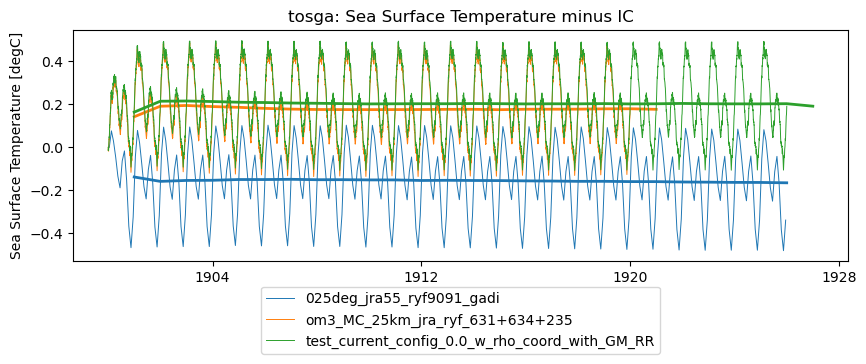

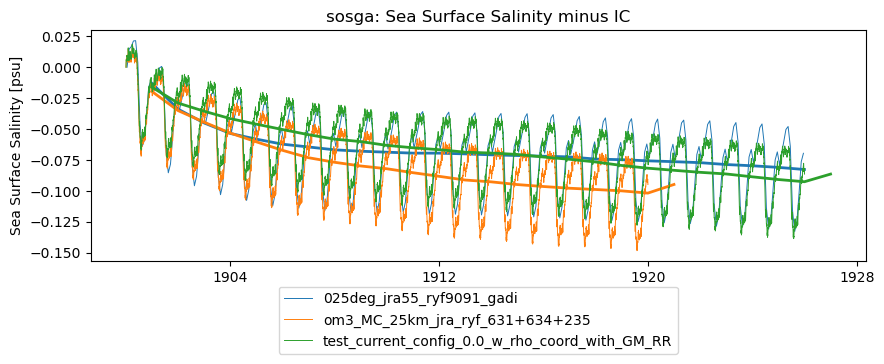

In [22]:
for k, d in data.items():
    print(k)
    fname = thisdir+k+'_'+list(d.values())[-1][k].attrs['long_name'].replace(' ', '_').replace('/','_')+'-IC.png'
    # print(fname)
    if False: #os.path.isfile(fname):
        print(f'---- skipping existing file {fname}')
    else:
        plt.figure(figsize=(10,5))
        ax = plt.subplot(111)
        for n, ds in d.items():
            dat = ds[k].sel(time=trange)
            if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
                dat = grid.average(dat, ['X', 'Y', 'Z'])
            elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
                dat = grid.average(dat, ['X', 'Y'])
            dat = dat - dat.isel(time=0)
            dat.load()
            # if int((dat.time[1]-dat.time[0]).values/1e9/60/60/24) == 1:
            #     label = 'daily'
            # else:
            #     label = 'monthly mean' # possible BUG: plausible guess
            # p = dat.plot(label=' '.join([n, label]), linewidth=1)
            p = dat.plot(label=n, linewidth=.7)
            dat.cf.resample(time='1YE').mean('time').plot(
                # label=' '.join([n, 'annual mean']),
                color=p[-1].get_color(),
                linewidth=2
            )
            # dat.cf.rolling(time=12, center=True).mean('time').plot()
            # dat.cf.rolling(time='1YE', center=True).mean('time').plot()
        # NB: title from first item (OM3), but y axis label from last item (may be OM2)
        # plt.title(k+': '+list(d.values())[0][k].attrs['long_name'])
        plt.title(f'{k}: {dat.attrs["long_name"]} minus IC')
        plt.xlabel('')
        plt.legend()
        # Shrink current axis's height from the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.4,
                         box.width, box.height * 0.6])
        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08))
        try:
            plt.savefig(fname, dpi=150)
            print(f'saved {fname}')
        except FileNotFoundError:
            print(f'*** FileNotFoundError when saving {fname}')
        # break

# OLD BELOW

In [19]:
fields_mean = ['thetaoga', 'tos', 'soga', 'sos', 'sss_global', 'SSH', 'volo', 'masso',]# 'KE']
data_mean = { k: datastore.search(variable=k, 
                                  frequency='1mon', 
                                  # variable_cell_methods='.*time: mean.*'
                                 ).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_mean }
data_mean = { k: list(v.values())[0] for k, v in data_mean.items() if v } # drop any empty datasets
data_mean

NameError: name 'datastore' is not defined

In [81]:
fields_min = [ 'SSH_min', 'mlotst_min','uh', 'vh' ]
data_min = { k: datastore.search(variable=k, 
                                 frequency='1mon', 
                                 variable_cell_methods='.*time: min.*'
                                ).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_min }
data_min = { k: list(v.values())[0] for k, v in data_min.items() if v } # drop any empty datasets
data_min

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


{'mlotst_min': <xarray.Dataset> Size: 2GB
 Dimensions:     (time: 348, yh: 1142, xh: 1440)
 Coordinates:
   * xh          (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
   * yh          (yh) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.95
   * time        (time) object 3kB 1920-01-16 12:00:00 ... 1948-12-16 12:00:00
 Data variables:
     mlotst_min  (time, yh, xh) float32 2GB dask.array<chunksize=(1, 1142, 1440), meta=np.ndarray>
 Attributes: (12/16)
     NumFilesInSet:                            1
     title:                                    ACCESS-OM3
     associated_files:                         areacello: access-om3.mom6.stat...
     grid_type:                                regular
     grid_tile:                                N/A
     intake_esm_vars:                          ['mlotst_min']
     ...                                       ...
     intake_esm_attrs:variable_standard_name:  ['', '', '', '', 'ocean_mixed_l...
     intake_esm_attrs:variable_cel

In [77]:
fields_max = [ 'SSH_max', 'mlotst_max', 'uh', 'vh' ]
data_max = { k: datastore.search(
    variable=k, 
    frequency='1mon', 
    variable_cell_methods='.*time: max.*'
).to_dataset_dict(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields_max }
data_max = { k: list(v.values())[0] for k, v in data_max.items() if v } # drop any empty datasets
data_max

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: There are no datasets to load! Returning an empty dictionary.
  return self.raw_function(**d, **var_kwargs)


{'mlotst_max': <xarray.Dataset> Size: 2GB
 Dimensions:     (time: 348, yh: 1142, xh: 1440)
 Coordinates:
   * xh          (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
   * yh          (yh) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.95
   * time        (time) object 3kB 1920-01-16 12:00:00 ... 1948-12-16 12:00:00
 Data variables:
     mlotst_max  (time, yh, xh) float32 2GB dask.array<chunksize=(1, 1142, 1440), meta=np.ndarray>
 Attributes: (12/16)
     NumFilesInSet:                            1
     title:                                    ACCESS-OM3
     associated_files:                         areacello: access-om3.mom6.stat...
     grid_type:                                regular
     grid_tile:                                N/A
     intake_esm_vars:                          ['mlotst_max']
     ...                                       ...
     intake_esm_attrs:variable_standard_name:  ['', '', '', '', 'ocean_mixed_l...
     intake_esm_attrs:variable_cel

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 15.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


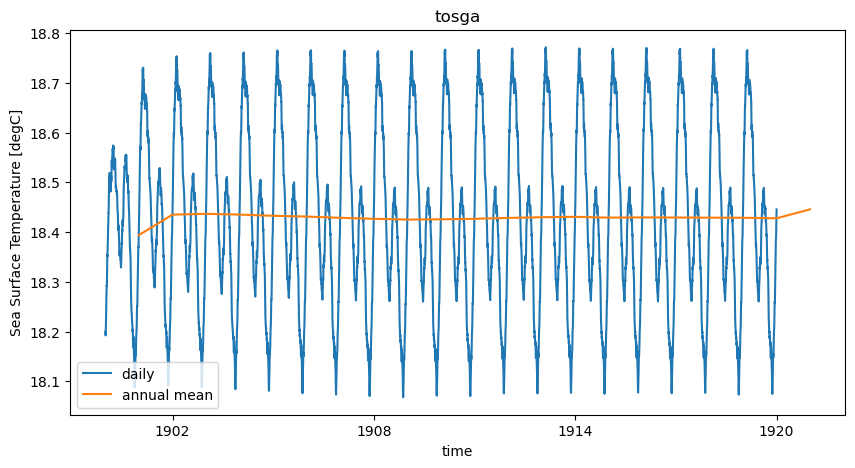

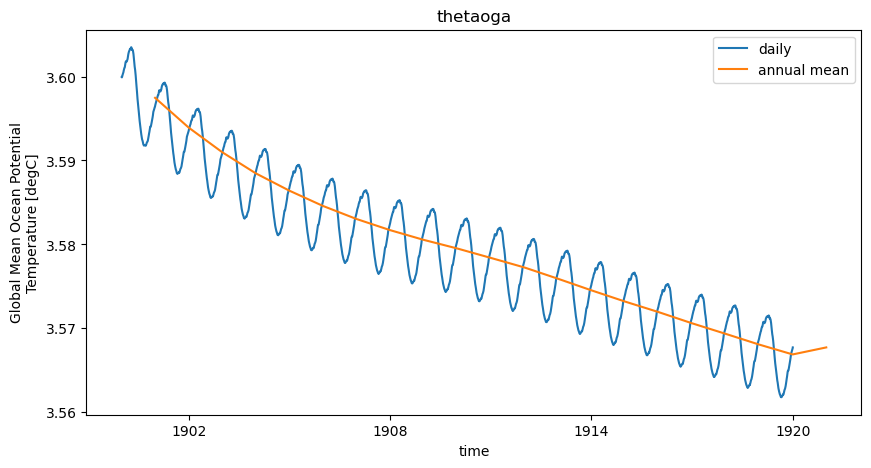

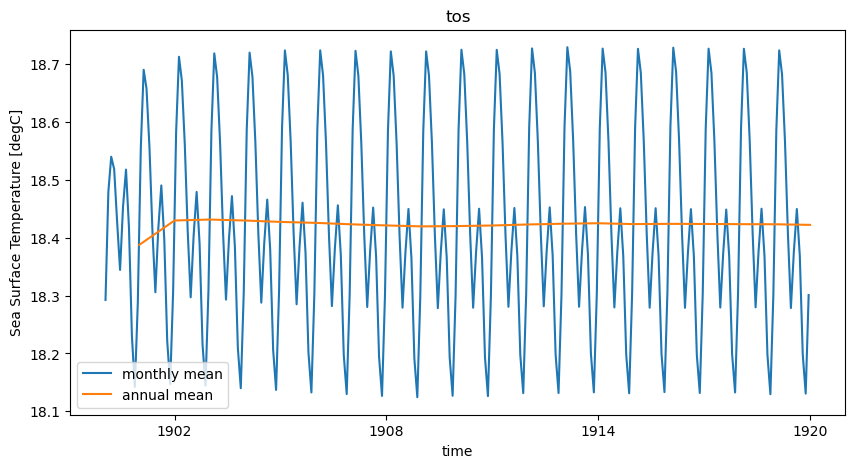

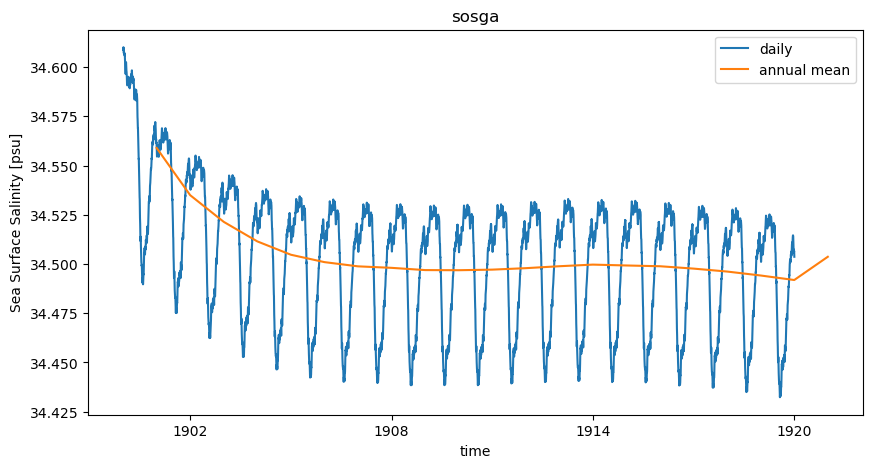

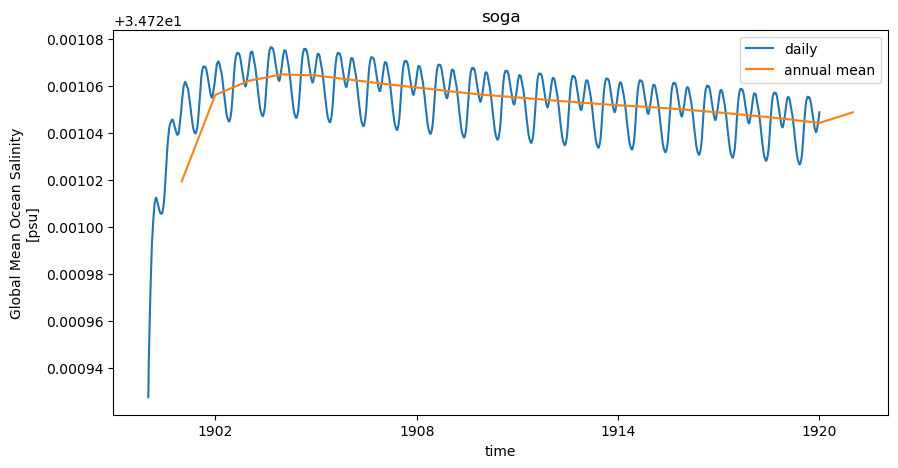

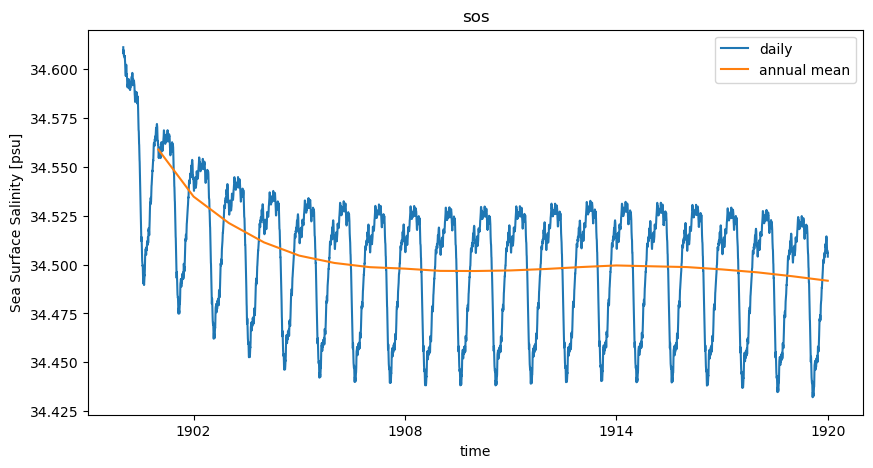

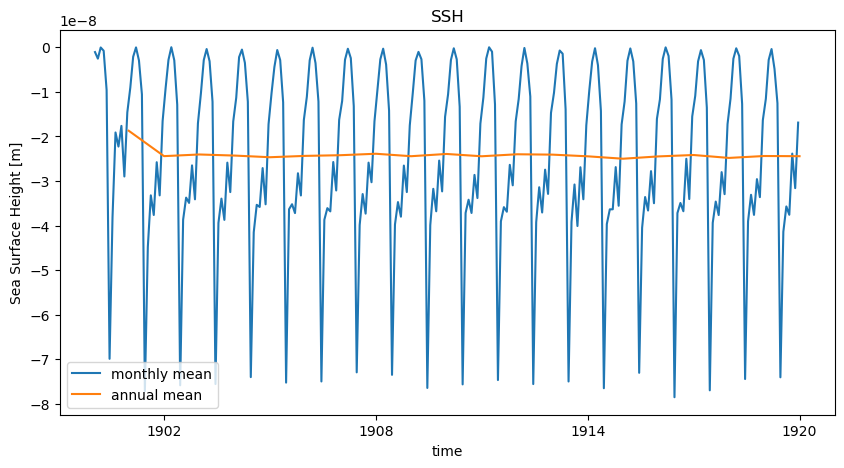

In [54]:
for k, d in data_mean.items():
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.average(dat, ['X', 'Y', 'Z'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.average(dat, ['X', 'Y'])
    dat.load()
    if int((dat.time[1]-dat.time[0]).values/1e9/60/60/24) == 1:
        label = 'daily'
    else:
        label = 'monthly mean' # BUG: wild guess
    plt.figure(figsize=(10,5))
    dat.plot(label=label)
    dat.cf.resample(time='1YE').mean('time').plot(label='annual mean')
    # dat.cf.rolling(time=12, center=True).mean('time').plot()
    # dat.cf.rolling(time='1YE', center=True).mean('time').plot()
    plt.title(k)
    plt.legend()
    # break

In [51]:
for k, d in data_min.items():
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.min(dim=['latitude', 'longitude', 'depth'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.min(dim=['latitude', 'longitude'])
    dat.load()
    plt.figure(figsize=(10,5))
    dat.plot()
    dat.cf.rolling(time=12, center=True).mean('time').plot()
    plt.title(k)

NameError: name 'data_min' is not defined

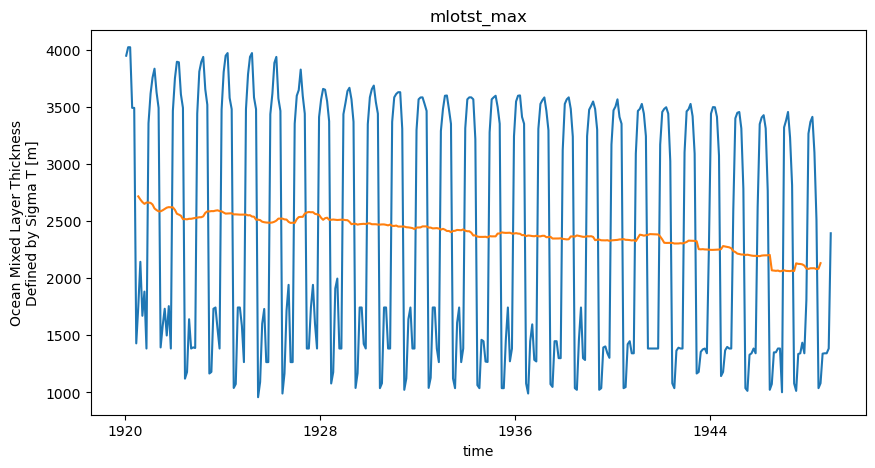

In [112]:
for k, d in data_max.items():
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.max(dim=['latitude', 'longitude', 'depth'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = dat.cf.max(dim=['latitude', 'longitude'])
    dat.load()
    plt.figure(figsize=(10,5))
    dat.plot()
    dat.cf.rolling(time=12, center=True).mean('time').plot()
    plt.title(k)